https://cosmicmar.com/muse_inference/advanced_examples.html#Jax

Muse is an approximate inference technique which combines MAP estimates with marginalization over stochastic latent variables to estimate parameters of interest.

In [1]:
%pylab inline
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem
import nfjax.shtlc as lc
import scipy.io

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


For this to work, we need a model structure that can take advantage of marginalization,

In [2]:
lmax, nlat, nlon, D = 16, 32, 64, 0.0004
_, L = lc.make_shtdiff(lmax=lmax, nlat=nlat, nlon=nlon, D=D, return_L=True)
np.testing.assert_equal(0, L.imag)
L = L.real.astype('f')

def apply_L(L, x, np=jnp):
    X = np.fft.rfft(x, axis=1)
    X = np.hstack(
        (np.einsum('abc,ca->ba', L, X[:,:lmax]),
         np.zeros((X.shape[0], X.shape[1] - lmax), jnp.complex64)
        )
    )
    y = np.real(np.fft.irfft(X, axis=1))
    return y

x0 = jnp.array(np.random.randn(nlat, nlon).astype('f'))
x1 = apply_L(L, x0)

scipy.io.savemat('L.mat', {'L':L})

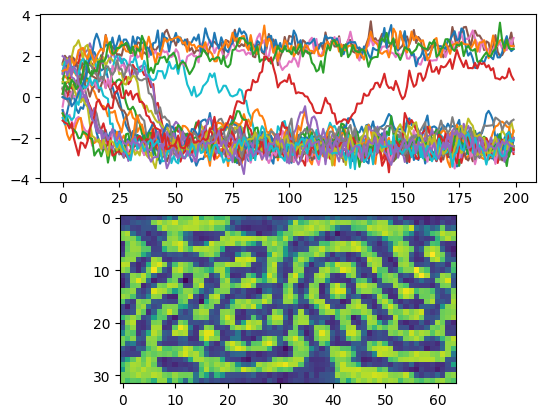

In [3]:
@jax.jit
def simulate(dt, x0, k, sig, zt):
    sqrt_dt = jnp.sqrt(dt)
    def f(x, z):
        lx = apply_L(L, x, np=jnp)
        x = x + dt * (x - x**3/3 + k * lx) + sqrt_dt * z * sig
        return x, x
    _, xt = jax.lax.scan(f, x0, zt)
    return xt

key = jax.random.PRNGKey(42)
zt = jax.random.normal(key, (200, ) + x0.shape)
sig = 1.0
dt = 0.1
k = 5.0
xt = simulate(dt, x0, k, sig, zt)

ion()
subplot(211); plot(xt[:,:5,:5].reshape((-1, 25)));
subplot(212); imshow(xt[-1])
show()

Let's see an animation

In [4]:
def show_movie(xt):
    import matplotlib.animation
    from IPython.display import HTML
    ioff()
    fig, ax = plt.subplots()
    l = ax.imshow(xt[0])
    def animate(i):
        l.set_data(xt[i])
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(xt), interval=50)
    ion()
    return HTML(ani.to_jshtml())

show_movie(xt)

The pattern seems fairly static, probably due to the long reach of the LC kernel?

Anyway, we can adapt the problem to muse like this:

In [5]:
class JaxFunnelMuseProblem(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def sample_x_z(self, key, θ):
        x0, sig, k = θ
        z = jax.random.normal(key, (200, ) + x0.shape)
        x = simulate(dt, x0, k, sig, z)
        return (x, z)

    def logLike(self, x, z, θ):
        return -jnp.sum((x - xt)**2)

    def logPrior(self, θ):
        x0, sig, k = θ
        e = jnp.sum(x0**2)
        return -e

In [6]:
prob = JaxFunnelMuseProblem()
key = jax.random.PRNGKey(0)
θ = x0, sig, k
(x, z) = prob.sample_x_z(key, θ)
prob.set_x(x)

/Users/duke/.local/share/virtualenvs/nfjax-Y-MGz7Lr/lib/python3.10/site-packages/jax/_src/api_util.py:222: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [7]:
%pdb

Automatic pdb calling has been turned ON


In [8]:
θ0 = x0*1.1, sig*1.1, k*1.1
result = prob.solve(θ_start=θ0, rng=jax.random.PRNGKey(1), progress=True)

get_H: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:34<00:00, 15.47s/it]


In [21]:
x0h, sigh, kh = result.θ
sig, sigh, k, kh

(1.0, Array(1.1, dtype=float32), 5.0, Array(5.5, dtype=float32))

We can also do this with NUTS of course, but interrupted because it takes a long time to run:

In [17]:
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO
import numpyro.distributions as dist
import numpyro

def logp(xt=None):
    x0h = numpyro.sample('x0h', dist.Normal(jnp.zeros((nlat, nlon)), 1))
    z = numpyro.sample('z', dist.Normal(jnp.zeros((len(xt), nlat, nlon)), 1))
    k_star = numpyro.sample('k_star', dist.Normal(0, 1))
    sig_star = numpyro.sample('sig_star', dist.Normal(0, 1))
    xth_mu = simulate(dt, x0h, jnp.exp(k_star), jnp.exp(sig_star), z)
    numpyro.sample('xth', dist.Normal(xth_mu, 1), obs=xt)

In [19]:
# numpyro.render_model(logp, model_args=(xt,), render_distributions=True)

In [13]:
nuts_kernel = NUTS(logp)
mcmc = MCMC(nuts_kernel, num_warmup=10, num_samples=10)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, xt=xt)

sample: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s, 1 steps of size 1.41e-04. acc. prob=0.20]
